Importing the libraries required

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats






In [ ]:
#Loading the dataset and reading the first five rows
data = pd.read_csv("/content/fmi_weather_and_price.csv")
data.head()

,Time,Wind,Temp,Price
0,2020-03-06 00:00:00,4.219394,-1.439604,1.70624
1,2020-03-06 01:00:00,4.273333,-1.583168,1.91456
2,2020-03-06 02:00:00,4.338182,-1.746535,1.85504
3,2020-03-06 03:00:00,4.289091,-1.900990,1.85876
4,2020-03-06 04:00:00,4.296341,-2.050249,1.89472


In [ ]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23039 entries, 0 to 23038
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    23039 non-null  object 
 1   Wind    23039 non-null  float64
 2   Temp    23039 non-null  float64
 3   Price   23039 non-null  float64
dtypes: float64(3), object(1)
memory usage: 720.1+ KB


The dataset contains 23,039 rows and 4 columns with no missing values. All numerical data are in floats, and the timestamp column (Time) is stored as an object.

In [ ]:
data.set_index('Time', inplace=True)

In [ ]:
# Basic statistics of the data
summary_stats = data.describe()
summary_stats

,Wind,Temp,Price
count,23039.000000,23039.000000,23039.000000
mean,4.269243,5.483564,9.962229
std,1.398702,9.212295,11.747785
min,1.331928,-22.126866,-0.214520
25%,3.207229,-0.818473,2.843320
50%,4.071951,5.611500,6.094600
75%,5.139329,12.652248,12.175560
max,11.025455,27.387129,124.008680


Based on the summary statistics, wind speed in Finland during the observed period ranges from 1.33 to 11.03 m/s, with an average of 4.27 m/s, indicating generally moderate wind conditions. The temperature shows a wide variation, from -22.13°C to 27.39°C, with a mean of 5.48°C, which reflects Finland's strong seasonal climate changes. Electricity prices also exhibit high volatility, ranging from -0.21 €/MWh to a peak of 124 €/MWh, with an average price of 9.96 €/MWh. This suggests that while the average price remains relatively stable, there are occasional extreme spikes likely driven by external market factors.

##**TIME SERIES ANALYSIS**

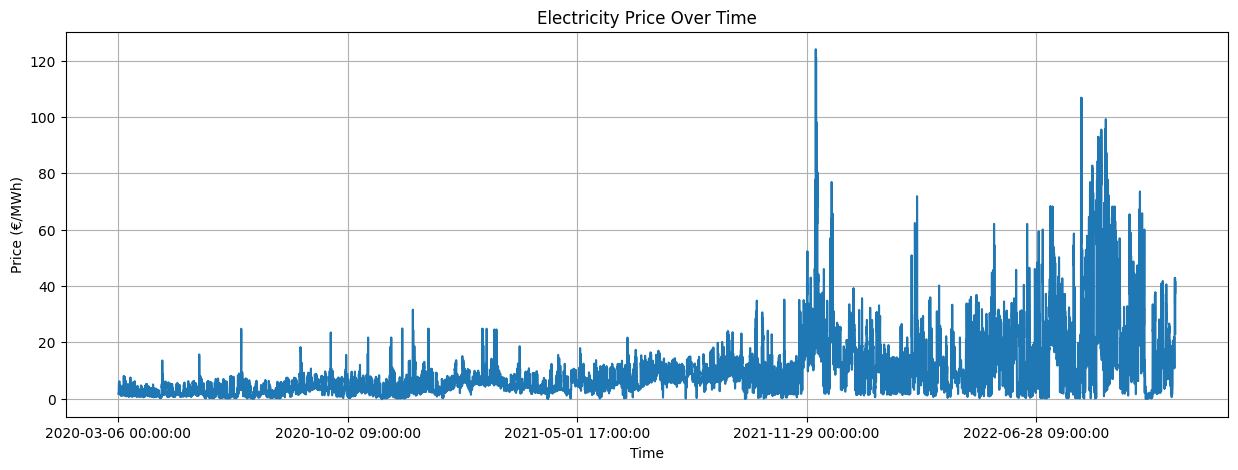

In [ ]:
# Plot time series for each variable
plt.figure(figsize=(15, 5))
data['Price'].plot(title='Electricity Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price (€/MWh)')
plt.grid(True)
plt.show()

From the electricity price time series chart, it is observe that prices remained relatively stable and low between March 2020 and November 2021, with only minor fluctuations. However, starting November 2021, there is a clear shift with frequent and significant spikes in electricity prices, peaking above €120/MWh. This sharp increase in volatility suggests that external factors—such as energy market disruptions, supply shortages, or geopolitical events—may have started influencing the Nordpool Spot prices in Finland more heavily from that point onward.

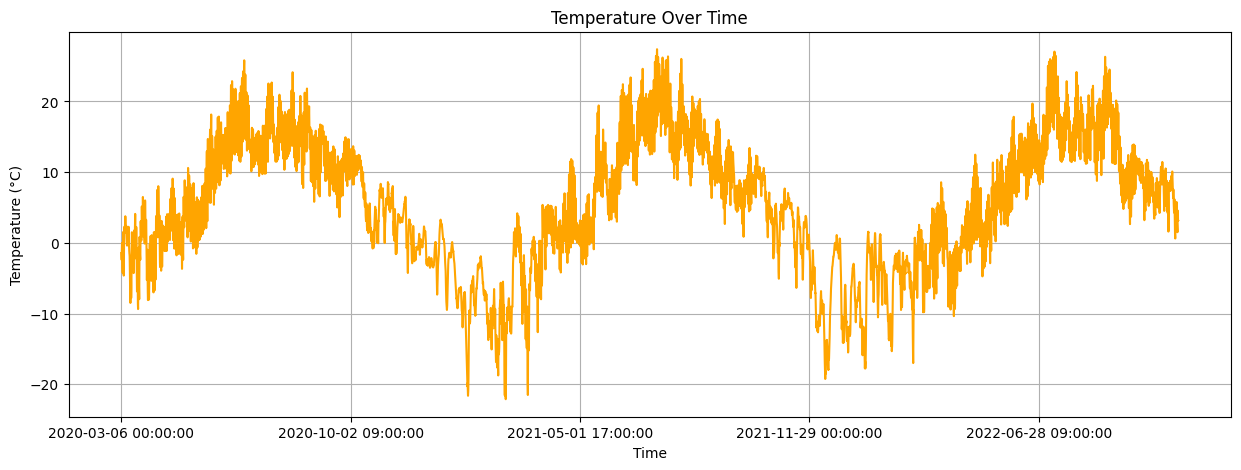

In [ ]:
plt.figure(figsize=(15, 5))
data['Temp'].plot(title='Temperature Over Time', color='orange')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()


The graph shows a clear seasonal temperature cycle in Finland, with high temperatures in summer and low temperatures in winter, repeating consistently each year. This pattern reflects typical seasonal climate variation, which can impact electricity demand.

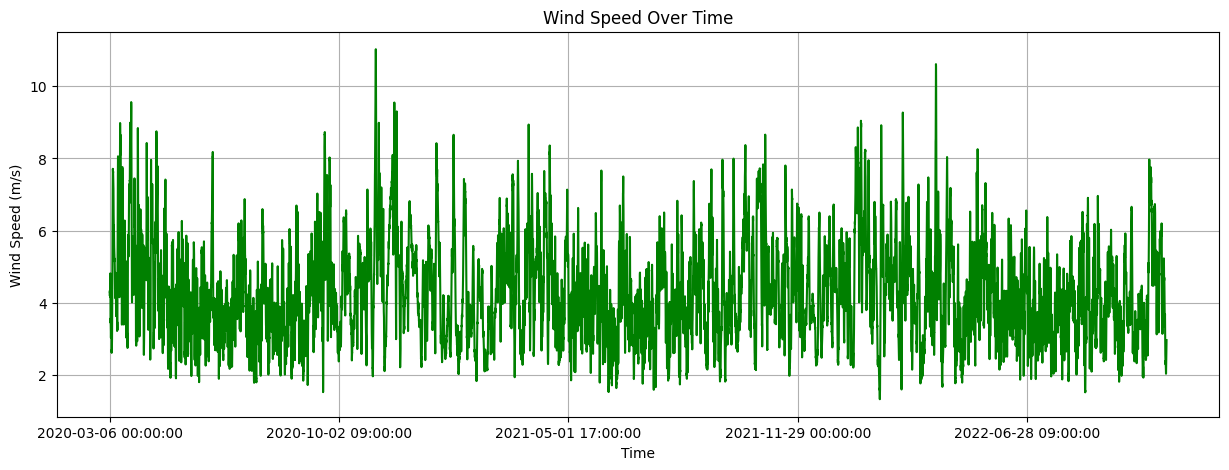

In [ ]:
plt.figure(figsize=(15, 5))
data['Wind'].plot(title='Wind Speed Over Time', color='green')
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()

The graph shows wind speed over time in Finland from 2020 to 2022. Wind speeds fluctuate regularly throughout the entire period, mostly ranging between 2 and 8 m/s, with occasional peaks above 10 m/s. Unlike temperature, wind does not display a clear seasonal pattern, but rather short-term variability. The consistency in fluctuation suggests that wind conditions are relatively stable year-round, with no strong upward or downward trend.

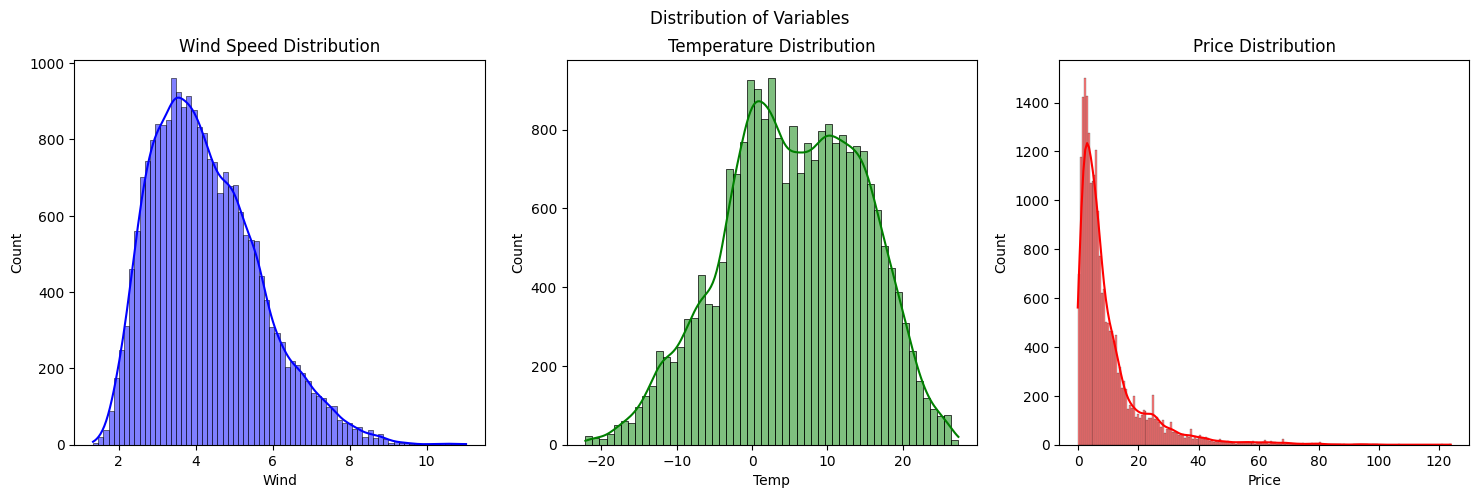

In [ ]:
# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Variables')

sns.histplot(data['Wind'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Wind Speed Distribution')

sns.histplot(data['Temp'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Temperature Distribution')

sns.histplot(data['Price'], kde=True, ax=axes[2], color='red')
axes[2].set_title('Price Distribution')


plt.show()

The distribution plots show that wind speed in Finland is mostly concentrated between 3 and 5 m/s, with a slightly right-skewed shape, indicating that moderate wind conditions are common. Temperature follows a roughly bimodal distribution, reflecting Finland’s seasonal climate with frequent occurrences around 0°C and 10°C. In contrast, electricity prices are highly right-skewed, with most values clustered between 0 and 20 €/MWh and a long tail reaching above 100 €/MWh, highlighting the presence of occasional but significant price spikes. This suggests that while weather conditions show natural variability, electricity prices are influenced by additional external market or supply-demand factors.

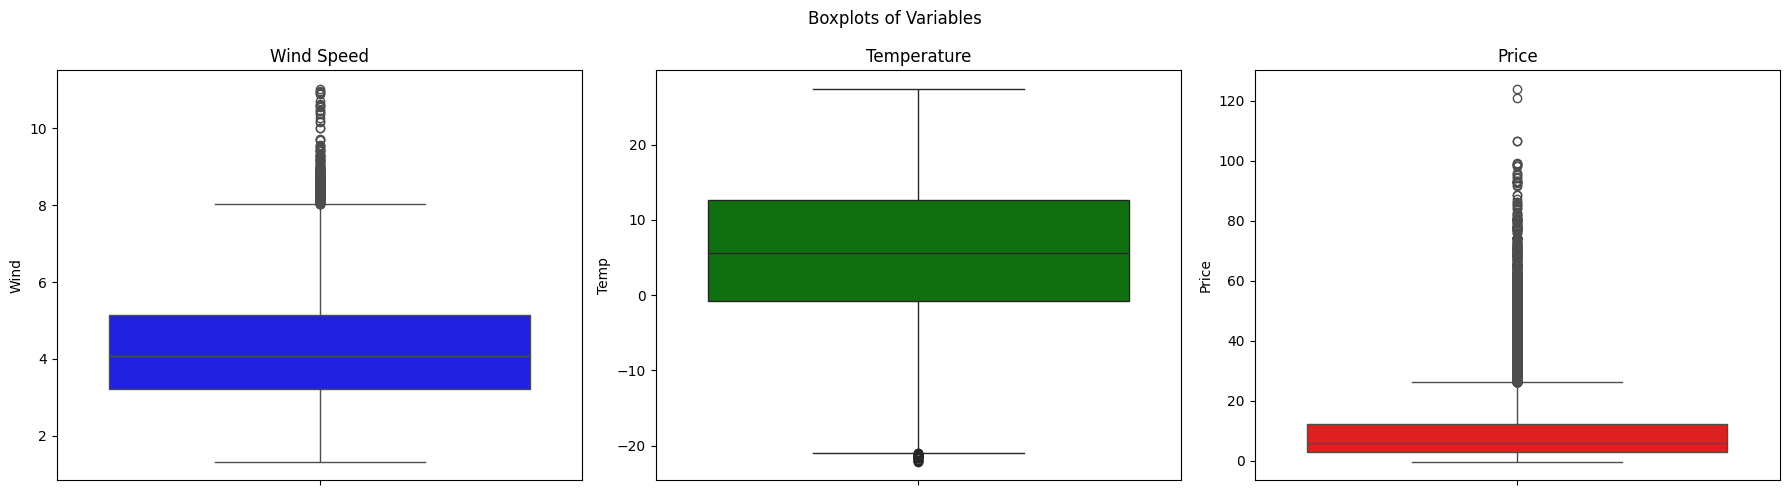

In [ ]:
# Boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Boxplots of Variables')

sns.boxplot(y=data['Wind'], ax=axes[0], color='blue')
axes[0].set_title('Wind Speed')

sns.boxplot(y=data['Temp'], ax=axes[1], color='green')
axes[1].set_title('Temperature')

sns.boxplot(y=data['Price'], ax=axes[2], color='red')
axes[2].set_title('Price')

plt.tight_layout()

plt.show()


The boxplots show that wind speed and temperature follow expected environmental patterns, with moderate variability and a few outliers. Wind mostly ranges between 2–6 m/s, and temperature spans from -22°C to 30°C, reflecting seasonal changes. In contrast, electricity prices exhibit high volatility with many extreme outliers above 100 €/MWh, indicating that prices are more influenced by external market factors than by regular weather variations.

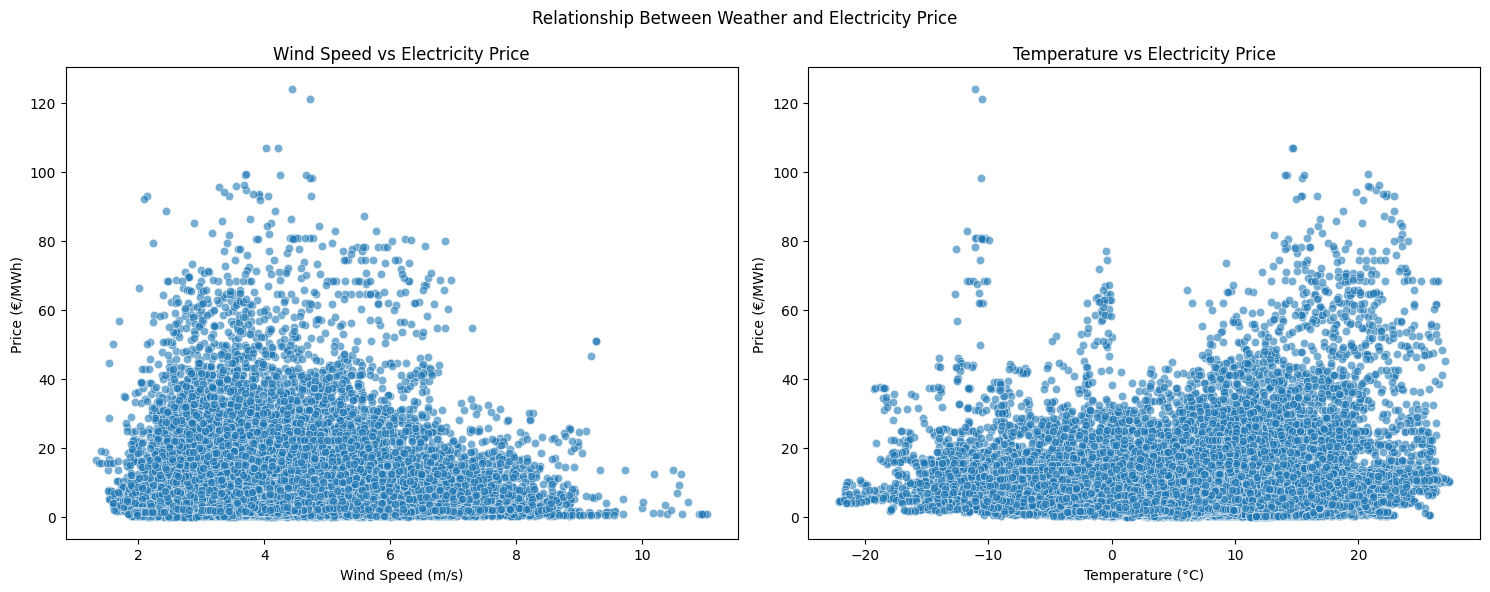

In [ ]:
# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Relationship Between Weather and Electricity Price')

sns.scatterplot(x='Wind', y='Price', data=data, ax=axes[0], alpha=0.6)
axes[0].set_title('Wind Speed vs Electricity Price')
axes[0].set_xlabel('Wind Speed (m/s)')
axes[0].set_ylabel('Price (€/MWh)')

sns.scatterplot(x='Temp', y='Price', data=data, ax=axes[1], alpha=0.6)
axes[1].set_title('Temperature vs Electricity Price')
axes[1].set_xlabel('Temperature (°C)')
axes[1].set_ylabel('Price (€/MWh)')

plt.tight_layout()
plt.savefig('scatter_plots.png')
plt.show()

The scatter plots suggest that electricity prices tend to be higher when wind speeds are low, indicating a possible inverse relationship between wind and price. Additionally, higher prices appear more frequently at both very low and very high temperatures, suggesting that extreme weather conditions—likely due to increased heating or cooling demand—may drive up electricity prices. Overall, weather conditions show some influence, but the relationship is not strongly linear.

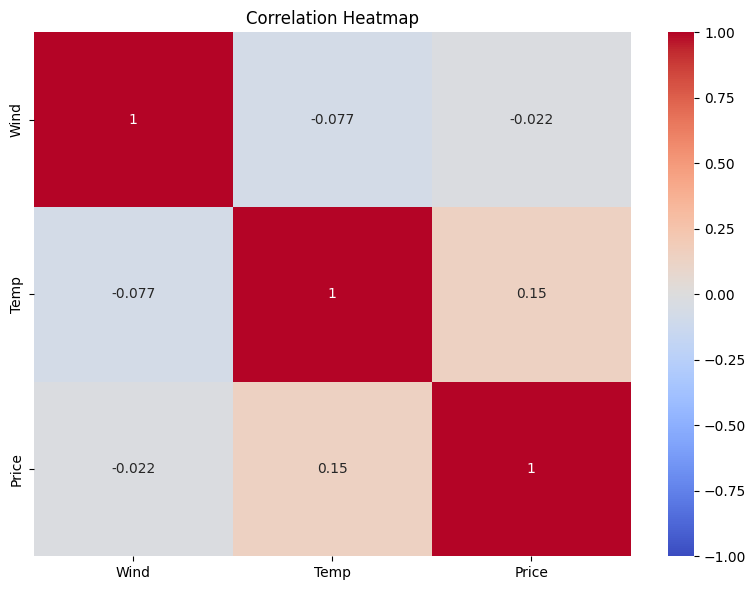

In [ ]:
corr_matrix = data[['Wind', 'Temp', 'Price']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


The correlation heatmap shows very weak relationships between weather conditions and electricity prices. Wind speed has almost no correlation with price (-0.02), while temperature shows a slightly positive but still weak correlation (0.15). This suggests that weather factors alone have limited influence on electricity price variations.

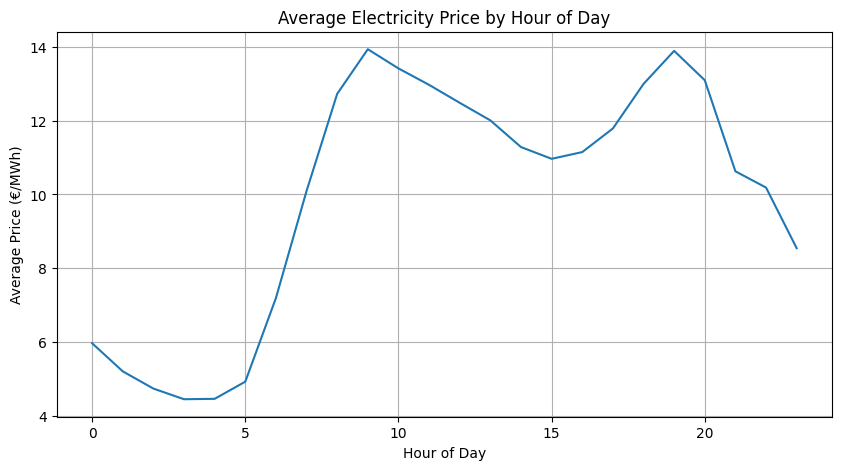

In [ ]:
# Convert index to datetime if it isn't already
data.index = pd.to_datetime(data.index)

# Hourly average prices
hourly_avg = data.groupby(data.index.hour)['Price'].mean()

plt.figure(figsize=(10, 5))
hourly_avg.plot()
plt.title('Average Electricity Price by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Price (€/MWh)')
plt.grid()
plt.show()

The graph shows that electricity prices are lowest during the night and early morning hours, then peak twice—once in the morning around 9–10 AM and again in the evening around 7–8 PM—reflecting typical daily demand patterns.

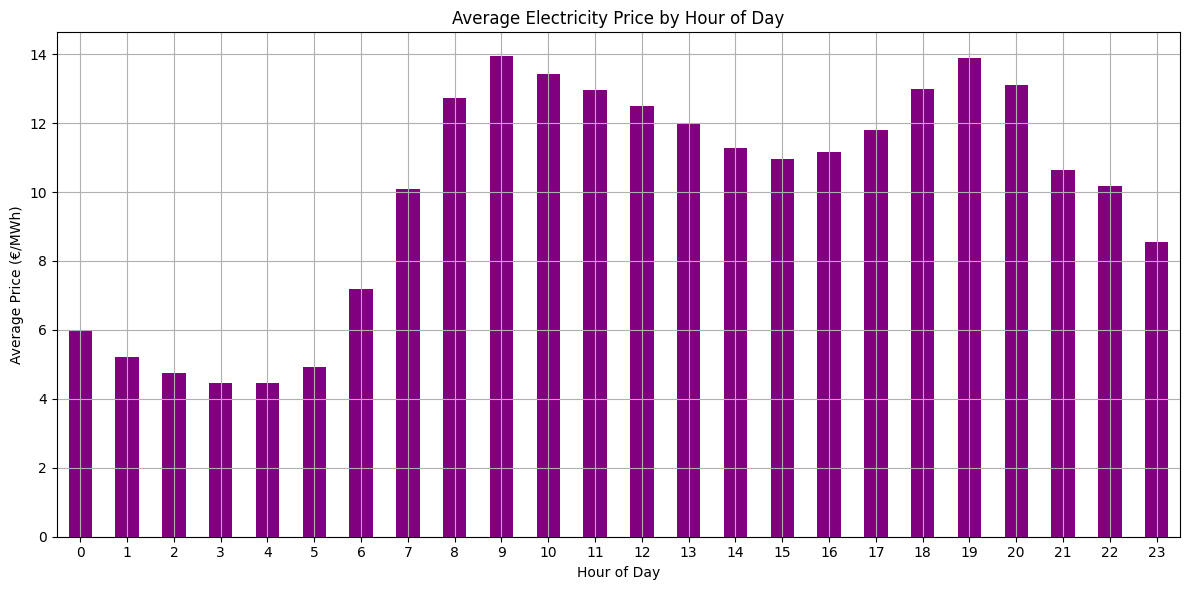

In [ ]:
plt.figure(figsize=(12, 6))
hourly_avg.plot(kind='bar', color='purple')
plt.title('Average Electricity Price by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Price (€/MWh)')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.savefig('hourly_patterns.png')
plt.show()


The graph shows that electricity prices are lowest during the night and early morning, then peak around 9–10 AM and again around 7–8 PM, reflecting higher demand during typical morning and evening activity hours.

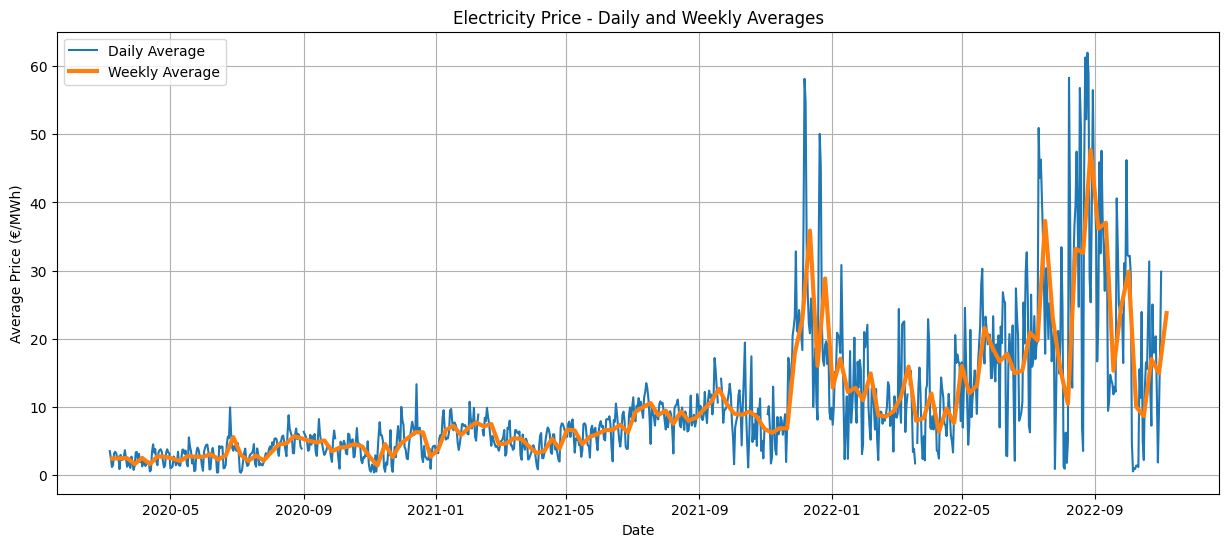

In [ ]:
# Daily and weekly resampling
daily_prices = data['Price'].resample('D').mean()
weekly_prices = data['Price'].resample('W').mean()

# Plot resampled data
plt.figure(figsize=(15, 6))
plt.plot(daily_prices, label='Daily Average')
plt.plot(weekly_prices, label='Weekly Average', linewidth=3)
plt.title('Electricity Price - Daily and Weekly Averages')
plt.xlabel('Date')
plt.ylabel('Average Price (€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

The graph shows the daily and weekly average electricity prices over time. From early 2020 to mid-2021, prices remained relatively stable and low, with only minor fluctuations. However, starting in late 2021, there is a noticeable and sharp increase in both daily and weekly averages, with several extreme price spikes reaching above €50/MWh. This upward trend continues into 2022, showing significantly more volatility than previous years.

<ipython-input-24-171f3a52ab8e>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_price = data.groupby('Temp_bin')['Price'].mean()


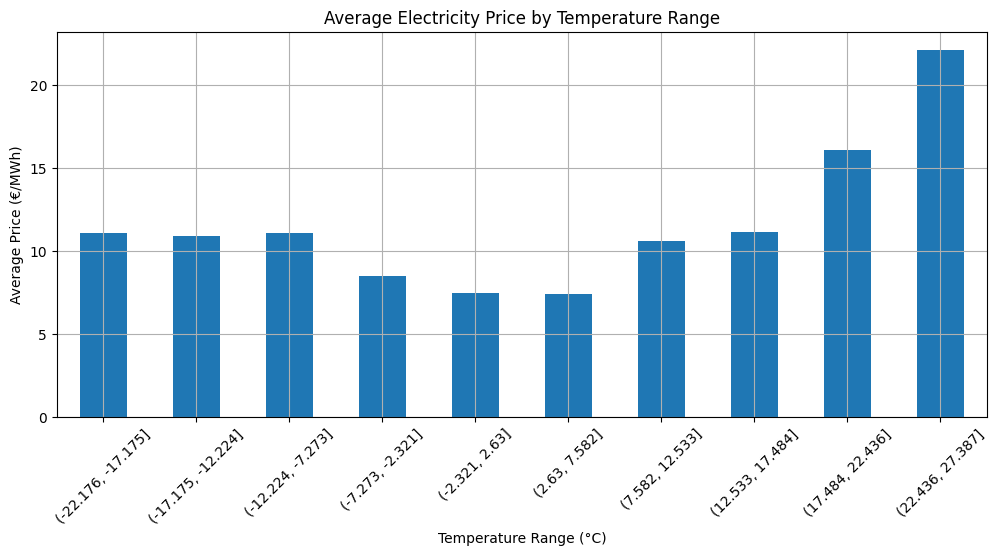

In [ ]:
# Temperature bins analysis
data['Temp_bin'] = pd.cut(data['Temp'], bins=10)
temp_price = data.groupby('Temp_bin')['Price'].mean()
plt.figure(figsize=(12, 5))
temp_price.plot(kind='bar')
plt.title('Average Electricity Price by Temperature Range')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Average Price (€/MWh)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



The chart shows that electricity prices are lowest at moderate temperatures and increase significantly at both very low and very high temperatures. This suggests that extreme weather conditions, due to higher heating or cooling demand, lead to higher electricity prices.

<ipython-input-25-8c501d292e7d>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_price = data.groupby('Wind_bin')['Price'].mean()


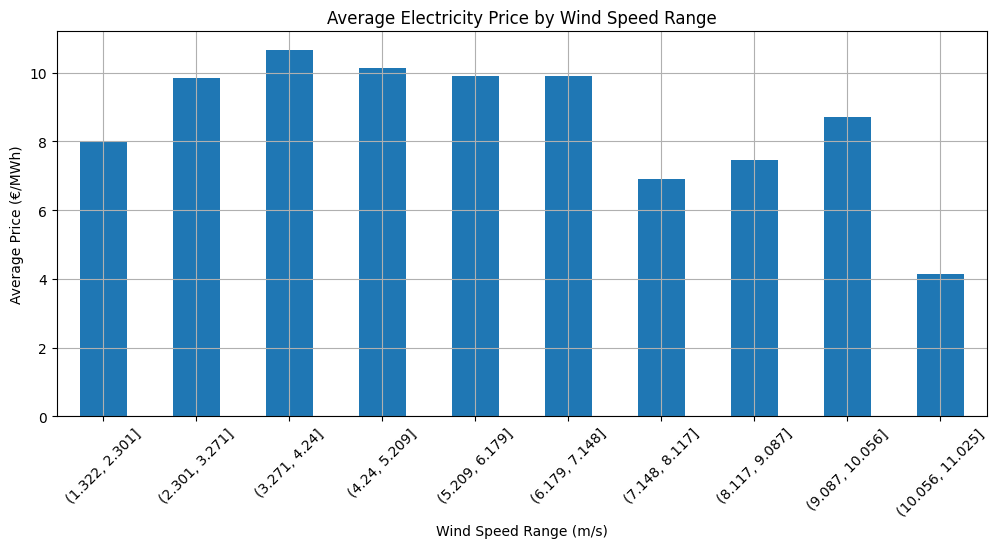

In [ ]:

# Wind speed bins analysis
data['Wind_bin'] = pd.cut(data['Wind'], bins=10)
wind_price = data.groupby('Wind_bin')['Price'].mean()
plt.figure(figsize=(12, 5))
wind_price.plot(kind='bar')
plt.title('Average Electricity Price by Wind Speed Range')
plt.xlabel('Wind Speed Range (m/s)')
plt.ylabel('Average Price (€/MWh)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The chart shows that electricity prices are highest at moderate wind speeds and decrease as wind speed increases. This suggests a slight inverse relationship, where higher wind speeds—likely contributing to more wind energy production—are associated with lower electricity prices.

In [ ]:
# Normality tests
for var in ['Wind', 'Temp', 'Price']:
    stat, p = stats.shapiro(data[var])
    print(f"\nShapiro-Wilk test for {var}:")
    print(f"Statistic: {stat:.3f}, p-value: {p:.3f}")
    if p > 0.05:
        print(f"{var} appears to be normally distributed")
    else:data


Shapiro-Wilk test for Wind:
Statistic: 0.966, p-value: 0.000

Shapiro-Wilk test for Temp:
Statistic: 0.991, p-value: 0.000

Shapiro-Wilk test for Price:
Statistic: 0.705, p-value: 0.000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23039.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
# Pearson correlation tests
wind_corr, wind_p = stats.pearsonr(data['Wind'], data['Price'])
temp_corr, temp_p = stats.pearsonr(data['Temp'], data['Price'])

print(f"Wind vs Price: r = {wind_corr:.3f}, p-value = {wind_p:.3f}")
print(f"Temperature vs Price: r = {temp_corr:.3f}, p-value = {temp_p:.3f}")

HYPOTHESIS TESTING


Null Hypothesis:
"Weather conditions (wind speed and temperature) have no statistically significant effect on Nordpool Spot electricity prices in Finland."


Alternative Hypothesis :
"Weather conditions (wind speed and/or temperature) have a statistically significant effect on Nordpool Spot electricity prices in Finland."


In [ ]:
# 2. Correlation Analysis
correlation_matrix = data[["Wind", "Temp", "Price"]].corr()
print("\nCorrelation matrix:\n", correlation_matrix)


Correlation matrix:
            Wind      Temp     Price
Wind   1.000000 -0.077010 -0.021841
Temp  -0.077010  1.000000  0.147867
Price -0.021841  0.147867  1.000000


In [ ]:
# 3. Hypothesis Testing with Linear Regression
# Define dependent (y) and independent variables (X)
X = data[["Wind", "Temp"]]  # Independent variables
X = sm.add_constant(X)     # Adds intercept term (beta_0)
y = data["Price"]            # Dependent variable

model = sm.OLS(y, X).fit() #fitting the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     258.8
Date:                Sat, 05 Apr 2025   Prob (F-statistic):          7.13e-112
Time:                        02:49:27   Log-Likelihood:                -89195.
No. Observations:               23039   AIC:                         1.784e+05
Df Residuals:                   23036   BIC:                         1.784e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3110      0.254     36.659      0.000       8.813       9.809
Wind          -0.0883      0.055     -1.609      0.108      -0.196       0.019
Temp           0.1875      0.008     22.502      0.000       0.171       0.204
==============================================================================
Omnibus:                    13598.369   Durbin-Watson:                   0.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           136120.241
Skew:                           2.729   Prob(JB):                         0.00
Kurtosis:                      13.584   Cond. No.                         37.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model is statistically significant overall (p < 0.001), but it explains only 2.2% of the variation in electricity prices, indicating low predictive power. Temperature has a significant positive effect on price, while wind speed is not significant. The residuals show signs of autocorrelation and non-normality, suggesting that model assumptions are violated and improvements are needed for better performance.

In [ ]:
# 4. Interpret p-values for hypothesis testing
print("\nHypothesis Testing Results:")
print(f"Wind p-value: {model.pvalues['Wind']:.4f}")
print(f"Temp p-value: {model.pvalues['Temp']:.4f}")


Hypothesis Testing Results:
Wind p-value: 0.1076
Temp p-value: 0.0000


From the result above, temperature has a statistically significant effect on electricity prices (p < 0.05).
Lower temperatures are linked to higher prices, likely due to increased heating demand.

Wind Speed is not statistically significant (p > 0.05). No strong evidence that wind speed affects electricity prices in this dataset.

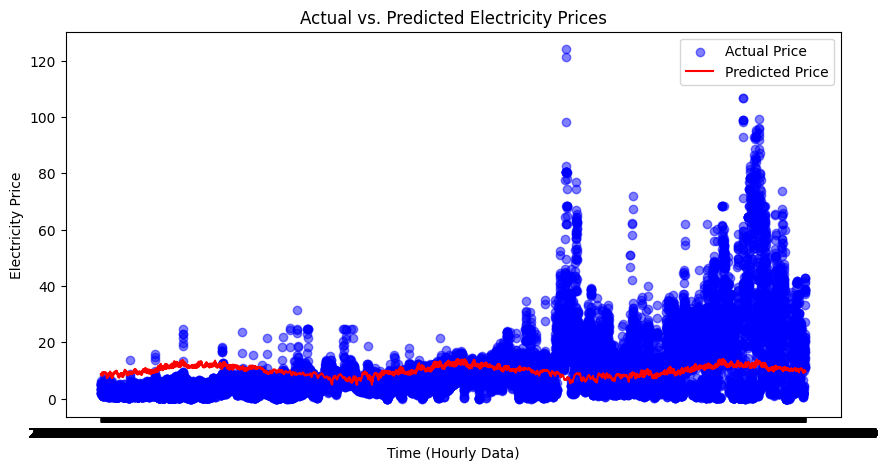

In [ ]:
# 5. Plot actual vs. predicted prices
plt.figure(figsize=(10, 5))
plt.scatter(data.index, y, color='blue', label='Actual Price', alpha=0.5)
plt.plot(data.index, model.predict(X), color='red', label='Predicted Price')
plt.xlabel("Time (Hourly Data)")
plt.ylabel("Electricity Price")
plt.title("Actual vs. Predicted Electricity Prices")
plt.legend()
plt.show()

The model predicts electricity prices fairly well during stable periods; however, it fails to capture large spikes in actual prices, consistently underestimating them. This suggests that while the model performs adequately under normal conditions, it struggles during volatile periods. Overall, the predictions are not accurate during high-price events, indicating a need for model improvement or the incorporation of additional features to better handle price fluctuations.

# FINDINGS, RESULTS AND CONCLUSIONS

The analysis tested whether weather conditions—specifically wind speed and temperature—significantly affect Nordpool Spot electricity prices in Finland. The results show a clear split: temperature has a statistically significant impact (p-value = 0.0000), while wind speed does not (p-value = 0.1076). This means colder temperatures likely drive higher electricity prices, possibly due to increased heating demand, but wind speed variations in this dataset did not demonstrate a measurable influence on pricing.

For temperature, the extremely low p-value (below the 0.05 threshold) provides strong evidence to reject the null hypothesis, confirming its role in price fluctuations. If the regression coefficient for temperature is negative, it would indicate an inverse relationship (lower temperatures = higher prices), aligning with seasonal energy demand patterns in Finland. Further visualization, like plotting temperature against price, could help illustrate this relationship more intuitively.

In contrast, the wind speed’s p-value suggests insufficient evidence to conclude it affects prices in this dataset. This could stem from limitations like short timeframes, insufficient wind variability, or unaccounted factors (e.g., grid storage or wind’s intermittent nature). To explore further, you might analyze lagged wind effects or nonlinear relationships (e.g., high winds triggering price drops due to surplus renewable generation).

Next steps include refining the model by incorporating additional variables (e.g., time-of-day effects or demand forecasts) or using time-series techniques to address autocorrelation. While temperature’s impact is clear, wind’s role may require deeper investigation or expanded data to uncover potential hidden relationships. This analysis lays a foundation for understanding weather-driven price dynamics but highlights the need for nuanced modeling to capture all influencing factors.